Student Information

Name: 鄭竹淇

Student ID: 109020032

GitHub ID: gigi-igig

Kaggle name: gigicc

Kaggle private scoreboard snapshot:49/99

[Snapshot](pic0.png)

#import package

In [1]:
import sys
from google.colab import drive
import numpy as np
import pandas as pd
import copy
import json as js
import itertools
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from xgboost.training import train

import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Take Home

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

### 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [2]:
#the path from colab
drive.mount('/content/drive')
path='/content/drive/My Drive/data mining/DM2023-Lab2-Master-main/'

Mounted at /content/drive


In [3]:
import pandas as pd

### training data
anger_train = pd.read_csv(path+"data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv(path+"data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv(path+"data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv(path+"data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [4]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [5]:
### testing data
anger_test = pd.read_csv(path+"data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv(path+"data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv(path+"data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv(path+"data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
# shuffle dataset
train_df = train_df.sample(frac=1, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [6]:
## save to pickle file
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

## Exercise 1 (Take home):
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


Text(0.5, 1.0, 'top 30 words in test')

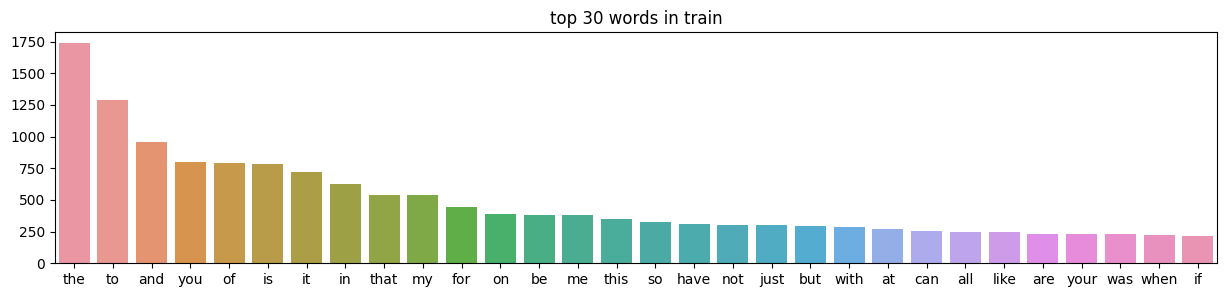

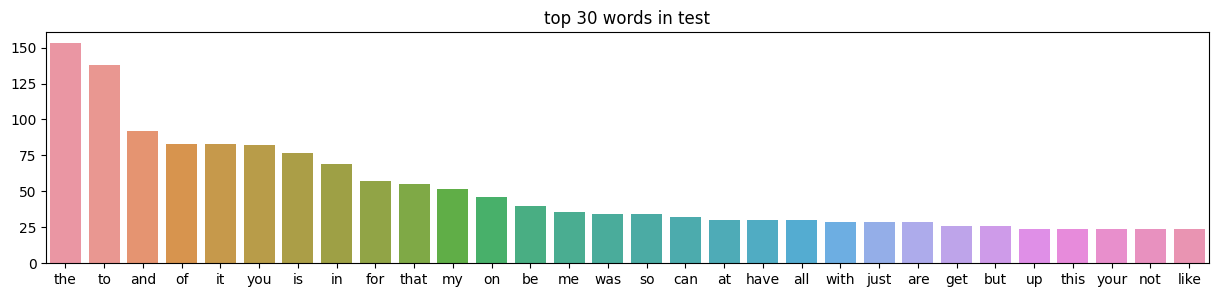

In [7]:
# Answer here

# train data
count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train_df.text)
train_freq = np.asarray(train_counts.sum(axis=0))[0]
train_freq_id = np.argsort(-train_freq)
train_freq_name=count_vect.get_feature_names_out()[train_freq_id]
# plot
plt.subplots(figsize=(15, 3))
g = sns.barplot(x=train_freq_name[:30], y=train_freq[train_freq_id[:30]])
g.set_xticklabels(train_freq_name[:30], rotation = 0, fontsize=10);
g.set_title('top 30 words in train')

# test data
count_vect = CountVectorizer()
test_counts = count_vect.fit_transform(test_df.text)
test_freq = np.asarray(test_counts.sum(axis=0))[0]
test_freq_id = np.argsort(-test_freq)
test_freq_name=count_vect.get_feature_names_out()[test_freq_id]
# plot
plt.subplots(figsize=(15, 3))
g = sns.barplot(x=test_freq_name[:30], y=test_freq[test_freq_id[:30]])
g.set_xticklabels(test_freq_name[:30], rotation = 0, fontsize=10);
g.set_title('top 30 words in test')

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [8]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer()

# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()

Let's try using another tokenizer below.

In [9]:

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()

##Exercise 2 (Take home):
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [10]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer
tf_1000 = TfidfVectorizer(max_features=1000)
tf_1000.fit(train_df['text'])
train_data_tf_features_1000 = tf_1000.transform(train_df['text'])
print("the shape of train_data_tf_features_1000: ", train_data_tf_features_1000.shape)
feature_names_1000 = tf_1000.get_feature_names_out()
feature_names_1000[100:110]

the shape of train_data_tf_features_1000:  (3613, 1000)


array(['bitter', 'black', 'blacks', 'blame', 'blessed', 'blood', 'bloody',
       'blues', 'body', 'boiling'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']


In [12]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)


---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [13]:
## accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
## precision, recall, f1-score,
#print(classification_report(y_true=y_test, y_pred=y_test_pred))

In [14]:
## check by confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

In [15]:
# Funciton for visualizing confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    #fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

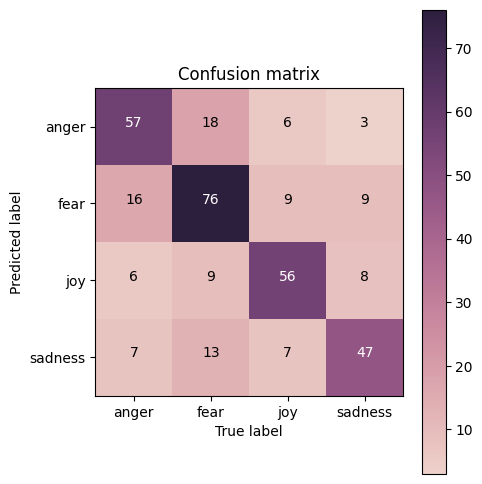

In [16]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

##Exercise 3 (Take home):
Can you interpret the results above? What do they mean?

              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



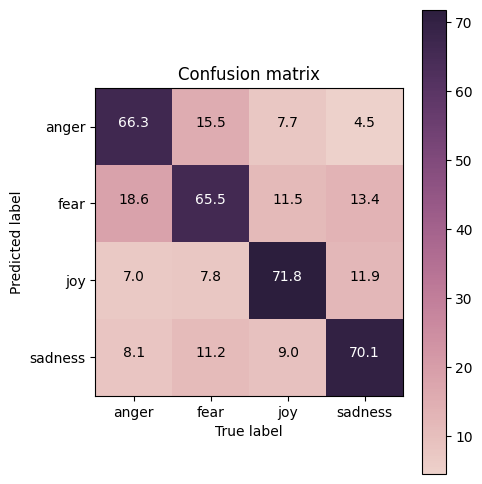

In [17]:
# Answer here
# In this result, label_"fear" has most correct data, because it has max support. However label_"joy" has higher precsision and recall.
print(classification_report(y_true=y_test, y_pred=y_test_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
cm_normalized = cm/cm.sum(axis=0)*100
plot_confusion_matrix(np.around(cm_normalized,1), classes=my_tags, title='Confusion matrix')
# It's a high probability that label_"anger" and label_"fear" are recognized as each other, so they are more similar.

##Exercise 4 (Take home):
Build a model using a ```Naive Bayes``` model and train it. What are the testing results?

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

training accuracy: 0.79
testing accuracy: 0.7
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



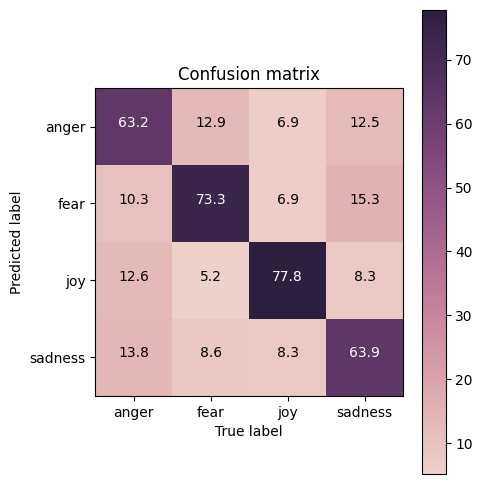

In [18]:
# Answer here
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_train_pred_bayes = mnb.predict(X_train)
y_test_pred_bayes = mnb.predict(X_test)

from sklearn.metrics import accuracy_score
acc_train_bayes = accuracy_score(y_true=y_train, y_pred=y_train_pred_bayes)
acc_test_bayes = accuracy_score(y_true=y_test, y_pred=y_test_pred_bayes)
print('training accuracy: {}'.format(round(acc_train_bayes, 2)))
print('testing accuracy: {}'.format(round(acc_test_bayes, 2)))

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_test_pred_bayes))
from sklearn.metrics import confusion_matrix
cm_bayes = confusion_matrix(y_true=y_test, y_pred=y_test_pred_bayes)
cm_normalized_bayes = cm_bayes/cm_bayes.sum(axis=0)*100
plot_confusion_matrix(np.around(cm_normalized_bayes,1), classes=my_tags, title='Confusion matrix')

##Exercise 5 (Take home):

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

In [19]:
# Answer here
print('Decision Tree model training accuracy: {}'.format(round(acc_train, 2)))
print('Decision Tree model testing accuracy: {}'.format(round(acc_test, 2)))
print('Naive Bayes model training accuracy: {}'.format(round(acc_train_bayes, 2)))
print('Naive Bayes model testing accuracy: {}'.format(round(acc_test_bayes, 2)))

# Decision Tree model might "overfitting", pruning may solve this problem.
# The two models have similar accuracy.

Decision Tree model training accuracy: 0.99
Decision Tree model testing accuracy: 0.68
Naive Bayes model training accuracy: 0.79
Naive Bayes model testing accuracy: 0.7


Decision Tree model
               precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347

Naive Bayes model
               precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



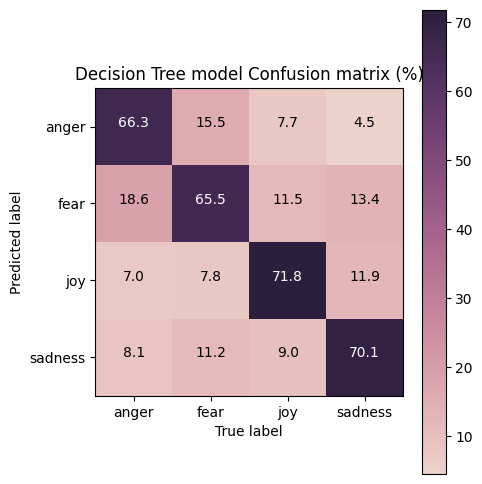

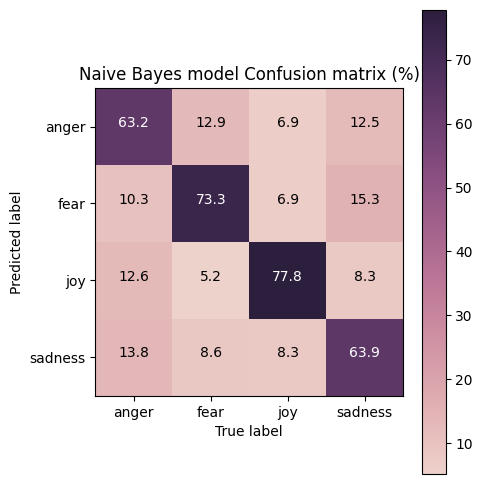

In [20]:
print("Decision Tree model\n", classification_report(y_true=y_test, y_pred=y_test_pred))
print("Naive Bayes model\n", classification_report(y_true=y_test, y_pred=y_test_pred_bayes))
plot_confusion_matrix(np.around(cm_normalized,1), classes=my_tags, title='Decision Tree model Confusion matrix (%)')
plot_confusion_matrix(np.around(cm_normalized_bayes,1), classes=my_tags, title='Naive Bayes model Confusion matrix (%)')
# Naive Bayes model is better on label_"fear" and label_"joy"
# Naive Bayes model assumes each class conditional are independent, however this example didn't conform to the rules.
# When the scale of train data is big enough, Naive Bayes model can avoid overfitting

---

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models.

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![Fully Connected Network](pics/pic1.png)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [21]:
# standardize name (X, y)
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves.

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [22]:
## deal with label (string -> one-hot)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 839     anger
2630      joy
32      anger
2398      joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [23]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](pics/pic2.png)

In [24]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

### 6.4 Train

In [25]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(path+'logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger], validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 2s 8ms/step - loss: 1.3259 - accuracy: 0.3676 - val_loss: 1.2630 - val_accuracy: 0.4841
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 0.9848 - accuracy: 0.6507 - val_loss: 0.9235 - val_accuracy: 0.6542
Epoch 3/25
113/113 [==============================] - 0s 1ms/step - loss: 0.5853 - accuracy: 0.7877 - val_loss: 0.7907 - val_accuracy: 0.6916
Epoch 4/25
113/113 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8450 - val_loss: 0.8208 - val_accuracy: 0.6974
Epoch 5/25
113/113 [==============================] - 0s 1ms/step - loss: 0.3370 - accuracy: 0.8752 - val_loss: 0.8457 - val_accuracy: 0.6945
Epoch 6/25
113/113 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.8998 - val_loss: 0.8875 - val_accuracy: 0.6974
Epoch 7/25
113/113 [==============================] - 0s 1ms/step - loss: 0.2303 - accuracy: 0.9222 - val_loss: 0.9791 - val_accuracy: 0.6888
Epoch 

### 6.5 Predict on testing data

In [26]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 3ms/step


array([[1.5767762e-03, 1.1725966e-05, 2.1672813e-02, 9.7673869e-01],
       [7.5691151e-09, 9.9997944e-01, 1.4743556e-06, 1.9038040e-05],
       [3.9689286e-05, 2.1625992e-03, 1.1888586e-05, 9.9778581e-01],
       [1.9327247e-04, 4.0807687e-02, 4.4982085e-06, 9.5899445e-01],
       [7.6350053e-03, 7.3709508e-08, 8.8184047e-01, 1.1052438e-01]],
      dtype=float32)

In [27]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['sadness', 'fear', 'sadness', 'sadness', 'joy'], dtype=object)

In [28]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.66


In [29]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv(path+"logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.367562,1.325917,0.484150,1.262961
1,1,0.650706,0.984753,0.654179,0.923545
2,2,0.787711,0.585284,0.691643,0.790704
3,3,0.845004,0.423012,0.697406,0.820754
4,4,0.875173,0.336951,0.694524,0.845731
5,5,0.899806,0.276325,0.697406,0.887528
6,6,0.922225,0.230313,0.688761,0.979141
7,7,0.938278,0.193127,0.694524,1.019670
8,8,0.952671,0.169830,0.685879,1.054384
9,9,0.955992,0.142399,0.697406,1.126216


## Exercise 6 (Take home):

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

<Axes: >

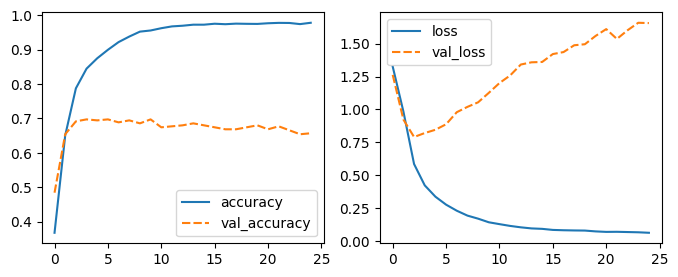

In [30]:
# Answer here
training_log
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 3), gridspec_kw={"width_ratios": [1, 1]})
sns.lineplot(data=training_log.loc[:,['accuracy','val_accuracy']], ax=ax1)
sns.lineplot(data=training_log.loc[:,['loss','val_loss']], ax=ax2)

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [31]:
# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
839,10839,Grateful for all the hungry people in my life!...,"[Grateful, for, all, the, hungry, people, in, ..."
2630,30626,only time I am ever cheering for you Johnny,"[only, time, I, am, ever, cheering, for, you, ..."
32,10032,I blame the whole season on Natalie! The seaso...,"[I, blame, the, whole, season, on, Natalie, !,..."
2398,30394,@AimiSyafiqahR go check up with your bf. He'll...,"[@, AimiSyafiqahR, go, check, up, with, your, ..."
411,10411,@JasonMillerinDC @realDonaldTrump Prudence sug...,"[@, JasonMillerinDC, @, realDonaldTrump, Prude..."


In [32]:
type(train_df['text_tokenized'][3])

list

In [33]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['Grateful', 'for', 'all', 'the', 'hungry', 'people', 'in', 'my', 'life', '!', 'Hungry', 'to', 'learn', ',', 'change', ',', 'grow', ',', 'help', ',', 'etc', '-', 'not', 'sure', 'anybody', 'has', 'it', 'better', '!', '#', 'relentless']),
       list(['only', 'time', 'I', 'am', 'ever', 'cheering', 'for', 'you', 'Johnny']),
       list(['I', 'blame', 'the', 'whole', 'season', 'on', 'Natalie', '!', 'The', 'season', 'would', 'have', 'been', 'so', 'different', 'had', 'she', 'not', 'turned', 'her', 'back', 'on', 'her', 'alliance', '!', '#', 'pissed'])],
      dtype=object)

In [34]:
len(training_corpus)

3613

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [35]:
## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus,
                          vector_size=vector_dim, window=window_size,
                          min_count=min_count, epochs=training_epochs)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [36]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.572979  ,  0.49459192, -0.01646973,  0.15191983, -0.6343206 ,
       -0.9994657 ,  0.56078655,  1.3111664 , -0.14586571, -0.67837673,
       -0.5977025 , -0.7464704 , -0.67340994,  0.69516814, -0.18707788,
       -0.671631  ,  0.17967796, -0.7544442 , -0.00869815, -1.0096895 ,
        0.7944511 ,  0.8055964 ,  0.67410713,  0.0880072 ,  0.18773223,
       -0.01895612, -0.9264928 ,  0.36320812, -0.36532304,  0.29616657,
       -0.11280904, -0.09246687,  0.09264833, -0.76433325, -0.11406566,
        0.69741744,  0.22032782, -0.34128916, -0.6036979 ,  0.06040182,
       -0.14704378, -0.33117986, -0.3509552 ,  0.17125085,  0.4899063 ,
       -0.15790367, -1.2489601 ,  0.40107536,  0.42788982,  0.6626211 ,
       -0.00212874, -0.50350314,  0.39221373,  0.00723254, -0.70792   ,
       -0.00460029,  0.37601593, -0.20766208,  0.1058625 , -0.15345298,
        0.18305731, -0.36944258,  0.7861498 ,  0.4342588 , -0.42254162,
        0.78810567,  0.26389405,  1.0180391 , -1.2687619 ,  0.19

In [37]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('bday', 0.9309757947921753),
 ('Be', 0.912327229976654),
 ('birthday', 0.9089556336402893),
 ("'be", 0.9055818319320679),
 ('cats', 0.9033389687538147),
 ('free', 0.8993315696716309),
 ('adventure', 0.8979228734970093),
 ('O', 0.897434413433075),
 ('Really', 0.897274911403656),
 ('cry', 0.8967419862747192)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [38]:
## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(path+model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [39]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [40]:
#w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])
glove_twitter_25_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

##Exercise 7 (Take home):

Now, we have the word vectors, but our input data is a sequence of words (or say sentence).
How can we utilize these "word" vectors to represent the sentence data and train our model?
The problem statement asks how to use word vectors to represent sentence data and train our model.

(補)
The requirement is to transform the input embedding from word vectors to sentence vectors.

(You need to at least print out the input data vector and tell us why that is sentence vector instead of word vector.)

However, if you want to use new training data to train the model and evaluate various input performances, it is recommended.

In [41]:
# Answer here
# average the words in this sentence
def get_sentence_vector_100dim(text_list):
  len_text = len(text_list)
  sentence_vector = np.zeros(100)
  for word in text_list:
    sentence_vector += word2vec_model.wv[word]
  sentence_vector = sentence_vector/len_text
  return sentence_vector
train_df['sentence_vec']=train_df['text_tokenized'].apply(lambda x: get_sentence_vector_100dim(x))

In [42]:
train_df['sentence_vec'][0]

array([-0.08404389,  0.34799242, -0.01665344,  0.58843283, -0.34564335,
       -0.93618888,  0.39343172,  1.3117276 , -0.46086094, -0.70135302,
        0.15727904, -0.75810613, -0.11923294,  0.57810119,  0.13038713,
       -0.16792165,  0.501804  , -0.49035741, -0.15078224, -1.1958829 ,
        0.34539969,  0.17406246,  0.52344714, -0.51746087,  0.10795125,
       -0.18910228, -0.58311564,  0.30863977, -0.49083526, -0.16093835,
        0.26644259,  0.05281456,  0.37362156, -0.47671248, -0.36684836,
        0.41377307,  0.49127976, -0.2584923 , -0.45932844, -0.22804175,
       -0.00929681, -0.09761683, -0.40623573, -0.01942664,  0.06242363,
       -0.14439952, -0.5064393 ,  0.2950862 ,  0.3595176 ,  0.63715401,
        0.08309736, -0.09848379, -0.1159006 ,  0.09341314, -0.22102576,
        0.18597   ,  0.39620676, -0.32332293, -0.12169806,  0.18254725,
        0.04593075,  0.06267136,  0.47953752, -0.00824087, -0.53749994,
        0.57055279, -0.09631433,  0.53894766, -0.7009049 ,  0.28

## 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [43]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [44]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![Imgur](pics/pic6.png)

In [45]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

In [46]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below:

![Image](pics/pic7.png)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [47]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

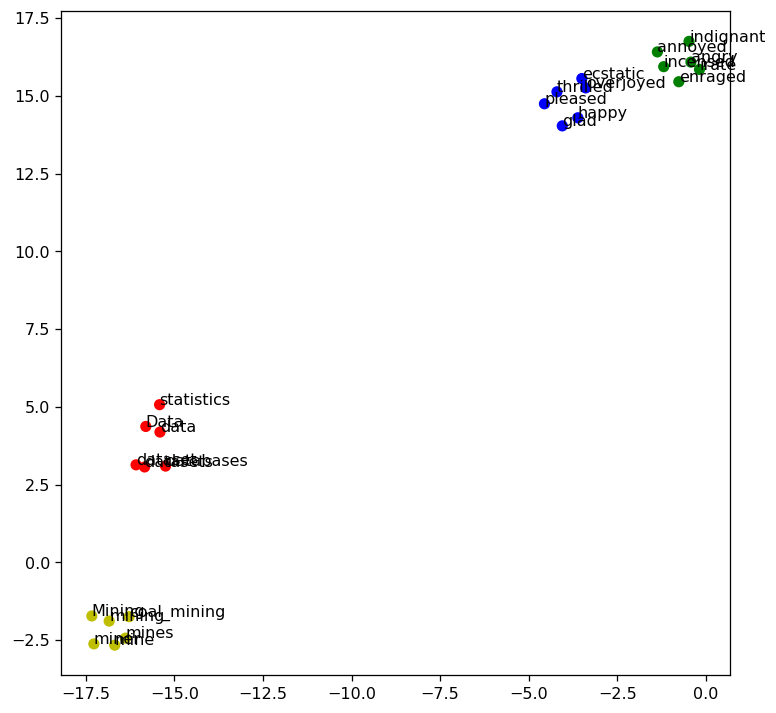

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

In [49]:
print("word_train:", word_train[20:30])
print("len_word_train:", len(word_train))
print("len_all_word:", len(all_word))
print(X_train.shape)

word_train: ['mines', 'coal_mining', 'mine', 'miner', '</s>', 'in', 'for', 'that', 'is', 'on']
len_word_train: 224
len_all_word: 3000000
(224, 300)


##Exercise 8 (Take home):

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).


target words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry', 'happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy', 'sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet', 'fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']
len target words:  64


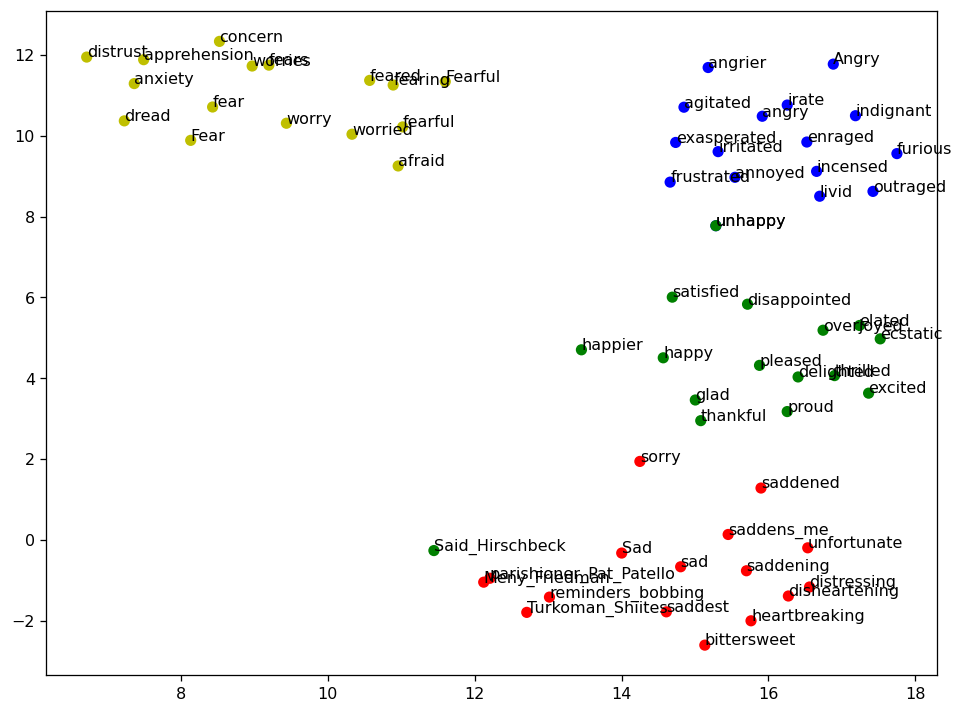

In [50]:
# Answer here
# create 60 words list
word_list = ['angry', 'happy', 'sad', 'fear']
topn = 15
target_words=[]
for chose_word in word_list:
  target_words.extend([chose_word])
  target_words.extend([word_ for word_, sim_ in w2v_google_model.most_similar(chose_word, topn=topn)])
print('\ntarget words: ', target_words)
print('len target words: ', len(target_words))

# create color list
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
#print('\ncolor list:', color)

# import
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(10, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---

#Kaggle model(use kaggle notebook)

##load data and make token

In [ ]:
my_path = '/kaggle/input/lab2data/'
data_ident = pd.read_csv(my_path+"data_identification.csv")
emotion = pd.read_csv(my_path+"emotion.csv")
filejson = open(my_path+"tweets_DM.json", "r")
jsonlines = []
for line in filejson.readlines():
    dic = js.loads(line)
    jsonlines.append(dic)
filejson.close()
df_nested_list = pd.json_normalize(jsonlines)
df = copy.deepcopy(df_nested_list.loc[:,['_score', '_crawldate', '_source.tweet.hashtags', '_source.tweet.tweet_id', '_source.tweet.text']])
df = df.rename({'_source.tweet.tweet_id':'tweet_id', '_source.tweet.hashtags':'hashtags', '_source.tweet.text':'text', '_score':'score'}, axis='columns')

In [ ]:
df['text_token'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
df['text_token'] = df['text_token'].apply(lambda x: x.tolist())

##split into train data, test data, validation data

In [ ]:
df_merg = pd.merge(df, data_ident, on=['tweet_id', 'tweet_id'])
train_data = pd.merge(df_merg[df_merg["identification"]=='train'], emotion, on=['tweet_id', 'tweet_id'])
test_data = df_merg[df_merg["identification"]=='test']
x_train, x_val, y_train, y_val = train_test_split(train_data.loc[:,['score','hashtags','text_token']], train_data['emotion'], test_size=0.25, random_state=33)

##label encoding

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_val = label_encode(label_encoder, y_val)

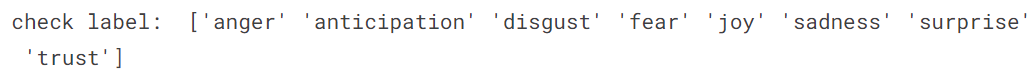

##Word2Vec and get feature

In [ ]:
from gensim.models import Word2Vec
training_corpus=x_train['text_token'].values
display(training_corpus[:3])
dim_size = 200
word2vec_model = Word2Vec(sentences=training_corpus, vector_size=dim_size, epochs=20, window=5, min_count=1)

In [ ]:
def get_sent_vec(model, text_list):
    len_text = len(text_list)
    sentence_vector = np.zeros(dim_size)
    if len_text ==0:
        return sentence_vector
    for word in text_list:
        if word in model.wv:
            sentence_vector += model.wv[word]
    sentence_vector = sentence_vector/len_text
    return sentence_vector

def get_feature(data, alpha=0.4):
    data['sent_vec'] = data['text_token'].apply(lambda x: get_sent_vec(word2vec_model,x))
    data['tags_vec'] = data['hashtags'].apply(lambda x: get_sent_vec(word2vec_model,x))
    return alpha*data['sent_vec']+(1-alpha)*data['tags_vec']

In [ ]:
x_train_feature = np.vstack(get_feature(x_train).values)
x_val_feature = np.vstack(get_feature(x_val).values)
x_test_feature = np.vstack(get_feature(test_data) .values)

##first XGboost model

In [ ]:
xgboostModel = XGBClassifier(n_estimators=150, learning_rate= 0.3)
# 使用訓練資料訓練模型
xgboostModel.fit(x_train_feature, y_train)
# 使用訓練資料預測分類
predicted_proba = xgboostModel.predict_proba(x_val_feature)

# 預測成功的比例
print('訓練集: ',xgboostModel.score(x_train_feature, y_train))
print('測試集: ',xgboostModel.score(x_val_feature, y_val))

NameError: ignored

In [ ]:
predicted_proba_test = xgboostModel.predict_proba(x_test_feature)
pred_result = label_decode(label_encoder, predicted_proba_test)
submissions = pd.DataFrame( data={'id':test_data['tweet_id'].reset_index(drop=True),
                                  'emotion':pred_result,})
#display(submissions)
submissions.to_csv("/kaggle/working/submission_xgb.csv",index=False)

##model

In [ ]:
# input layer
model_input = Input(shape=(dim_size, ))  # 100
X = model_input
# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)
# 2nd hidden layer
H1_W2 = Dense(units=32)(H1)  # 64
H2 = ReLU()(H1_W2)
# output layer
H2_W3 = Dense(units=8)(H2)  # 8
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# show model construction
model.summary()

In [ ]:
csv_logger = CSVLogger('/kaggle/working/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(x_train_feature, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger],
                    validation_data = (x_val_feature, y_val))
print('training finish')

In [ ]:
training_log = pd.DataFrame()
training_log = pd.read_csv("/kaggle/working/training_log.csv")
training_log

In [ ]:
pred_result = model.predict(x_test_feature, batch_size=128)
pred_result_label = label_decode(label_encoder, pred_result)
submissions = pd.DataFrame( data={'id':test_data['tweet_id'].reset_index(drop=True),
                                  'emotion':pred_result_label,})
submissions.to_csv("/kaggle/working/submission_model.csv",index=False)

##second XGboost model

In [ ]:
x_result = model.predict(x_train_feature, batch_size=128)
# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=150, learning_rate= 0.3)
# 使用訓練資料訓練模型
xgboostModel.fit(x_result, y_train_label)
# 使用訓練資料預測分類
predicted = xgboostModel.predict(pred_result)
pred_result_2 = np.array(emo_list[x] for x in predicted)
submissions = pd.DataFrame( data={'id':test_data['tweet_id'].reset_index(drop=True),
                                  'emotion':pred_result_2,})
display(submissions)
submissions.to_csv("/kaggle/working/submission_model_XGB.csv",index=False)
# 預測成功的比例
#print('訓練集: ',xgboostModel.score(x_train_feature, y_train_label))
#print('測試集: ',xgboostModel.score(x_val_feature, y_val_label))

#finish